# SNR Report Tests

This will be performed on the Siemens 'long bottle' phantom in the most used head coil. This is the phantom used for the Siemens coil QA and it can be easily positioned using the dedicated Siemens foam pad.

### Boiler plate

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.reports import snr_report
from mriqa.tools import mean_im, diff_im, snr_im, snr
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings

### Multi Element SNR Analysis

### Combined Element SNR Analysis

In [2]:
patid = 'PQACRK20161215'
studyid = '1'
series = {
    'Signal': [26, 30],
    'Signal_Combined': [27, 31],
    'Noise': [22, 24],
    'Noise_Combined': [23, 25],
    'Geometry': [28, 32]
}

### Individual coil element images
We can use a *mask-like* field in the Siemens CSA header to identify individual coil elements.

In [3]:
# Assume just one element - only one 'X' in string.
def coil_element(dobj):
    return csa(dobj, 'image')['UsedChannelString'].index('X')

dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Signal']),
    key=lambda x: (int(x.SeriesNumber), coil_element(x))
)

### Acquisition parameters

In [4]:
nobjs = len(dobjs)
print('Images    = %d' % nobjs)
# Acquisition parameters
d = dobjs[0]
print('TR/TE     = %d / %d ms' % (d.RepetitionTime, d.EchoTime))
print('Matrix    = %d x %d'    % (d.Rows, d.Columns))
print('Sequence  = %s'         % d.SequenceName)
print('FoV       = %d x %d mm' % (d.Rows * d.PixelSpacing[0], d.Columns * d.PixelSpacing[1]))
print('Bandwidth = %d Hz'      % d.PixelBandwidth)
print('Phase Enc.= %s'         % d.InplanePhaseEncodingDirection)

nseries = len(series['Signal'])
nchannels = len(dobjs) // nseries
elements = [coil_element(d) for d in dobjs[:nchannels]]
nelements = len(elements)
print('Elements  = %s (%d)' % (elements, nelements))
assert nelements * nseries == nobjs

Images    = 64
TR/TE     = 500 / 20 ms
Matrix    = 256 x 256
Sequence  = *se2d1
FoV       = 250 x 250 mm
Bandwidth = 260 Hz
Phase Enc.= ROW
Elements  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] (32)


### Display element images

In [9]:
# check details
nseries = len(series['Signal'])
nchannels = len(dobjs) // nseries
imgarray = np.asarray([d.pixel_array & 0xfff for d in dobjs])
imgarray = imgarray.reshape(nseries, nchannels, *imgarray.shape[1:])
coil_images = imgarray.mean(axis=0)

In [5]:
def show_coil_mosaic(dobjs, dobjsb, op='mean', cmap=None):
    '''Display a list of dicom coil element images as a mosaic

       dobjs : Sequence of dicom objects to display
       dobjsb : Sequence of dicom objects to average or deffeence first with

       cmap : Optional colour map
    '''
    images = np.asarray([d.pixel_array & 0xfff for d in dobjs], dtype='int16')
    # if two series, take avarage
    if dobjsb is not None:
        imagesb = np.asarray([d.pixel_array & 0xfff for d in dobjsb], dtype='int16')
        if op == 'mean':
            images = (images + imagesb) / 2
        elif op == 'diff':
            # nb signed
            images = images - imagesb
    nimages = len(images)
    nx = int(round(np.sqrt(nimages)))
    ny = int(np.ceil(nimages / nx))
    if nx == 0 or ny == 0:
        nx = ny = 1
    fig, axs = plt.subplots(ny, nx, sharex=True, sharey=True, figsize=(3*nx, 3*ny))
    try:
        axs[0]
    except (TypeError, IndexError):
        axs = np.asarray([axs]).reshape((1, 1))

    vmax = 0.75 * images.max()
    vmin = 0.75 * images.min()
    for i, image in enumerate(images):
        axs[i // nx, i % nx].imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
        axs[i // nx, i % nx].axis('off')
        axs[i // nx, i % nx].set_title('Element %d' % (coil_element(dobjs[i])+1))

    if nimages < nx*ny:
        # pad out grid
        for i in range(nimages, nx*ny):
            axs[i // nx, i % nx].imshow(np.zeros_like(images[0]), vmin=vmin, vmax=vmax, cmap=cmap)
            axs[i // nx, i % nx].axis('off')
    fig.tight_layout()
    return

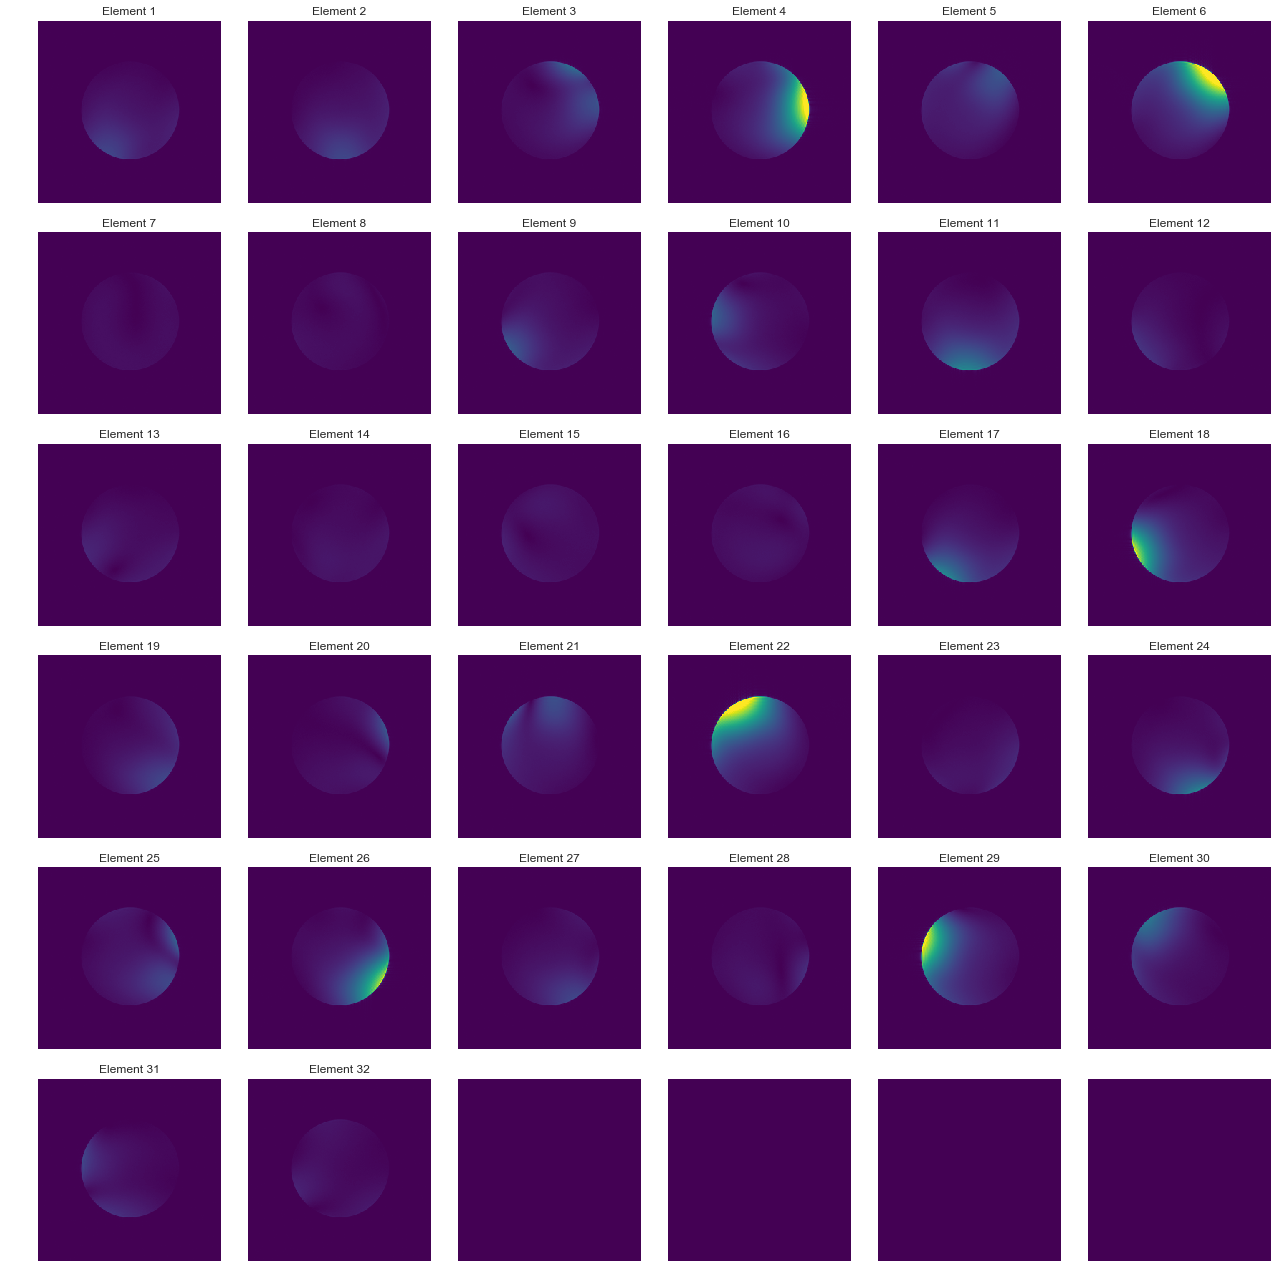

In [6]:
show_coil_mosaic(dobjs[:nchannels], dobjs[nchannels:], cmap='viridis')

### Calculate aggregate SNR based on Combined images.
Our current standard SNR measurement. Take a pair of acquisitions and use the standard deviation of a background ROI in difference image for noise. NB there may be issues with subtraction artefacts - we could limit ourself to a block of background in the frequency encoding direction. 

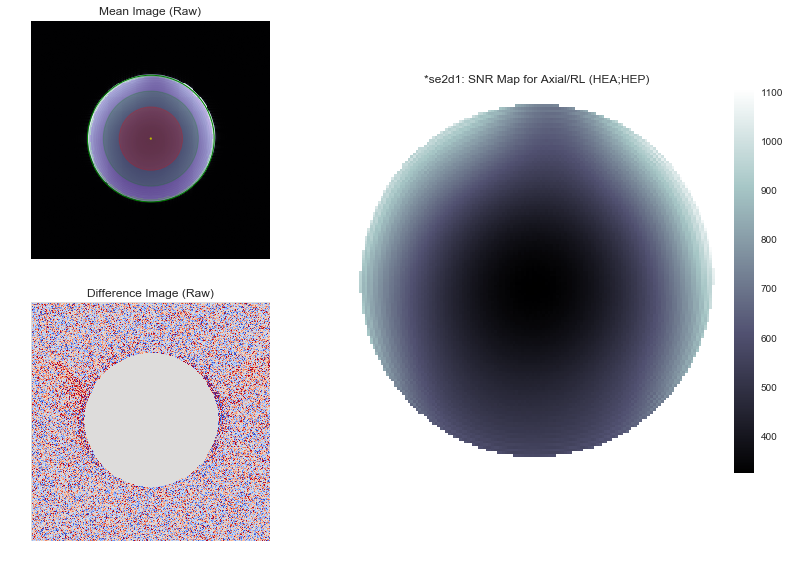

In [7]:
# LONGBOTTLE: Signal to Noise
raw_tra = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])

# or we could do the RMS coil combination combination ourselves to be sure ...

In [8]:
results.T

0.50        0.75
HEA;HEP  404.921058  493.279315

There are several ways of estimating the background noise. We can try and do it from  a single image in which case we expect that the noise will be distributed as a Rician in the foreground areas, ultimately reducing to a Rayleigh distribution in the background. We also expect that, at least for a single coil image, the noise to be stationary across the image. The disadvantage of using the statistics in the foreground is primarily that it is very sensitive to non-noise variations in the signal intensity eg from non-uniformity or artifacts. There is also a slight bias in taking the standard deviation rather than fitting the parameters of a Rician. As we expect the noise to be stationary we could use the background instead to estimate the noise. In that case we really do need to fit a Rayleigh distribution as the standard devation would be significantly biased. We want to go back to the standard deviation of the bivariate Gaussian of the complex data.

Alternatively, we can acquire the two image and work with their signed difference. We'd expect the noise statistics then to approximately Gaussian, both in the foreground and the background (though I'm not sure how to prove this). We still need to make some correction to get the original noise standard deviation.

Even taking the difference, it is clear looking at these difference images that there is some spatial variation remaining. Some appears to be a gain change, some subtraction artefacts. These seem worse in the foreground area as might be expected taking the difference of two large numbers. There is still some variation that looks like ghosting in the phase encoding direction. We could obviate this by taking our background ROI to be in the readout direction.

Another way of reducing the impact of non-noise variation is to work with spatial derivatives of the images. There is a method due to [Immerkaer](http://www.sciencedirect.com/science/article/pii/S1077314296900600). This can be further improved by explicitly excluding edge pixels from consideration. We can also apply the method in overlapping patches to 
generate a "noise" image.

In [19]:
raw_a, raw_b = raw_tra[0].pixel_array.astype(int), raw_tra[1].pixel_array.astype(int)
print(raw_a.min(), raw_a.max())
print(raw_b.min(), raw_b.max())
raw_diff = raw_a -raw_b
print(raw_diff.min(), raw_diff.max())

0 3273
0 3263
-29 24


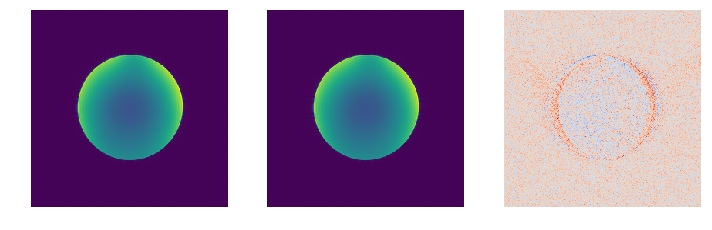

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(raw_a, cmap='viridis')
ax[0].grid(False)
ax[0].axis('off')
ax[1].imshow(raw_b, cmap='viridis')
ax[1].grid(False)
ax[1].axis('off')
ax[2].imshow(raw_diff, cmap='coolwarm')
ax[2].grid(False)
ax[2].axis('off');


4.12874345819


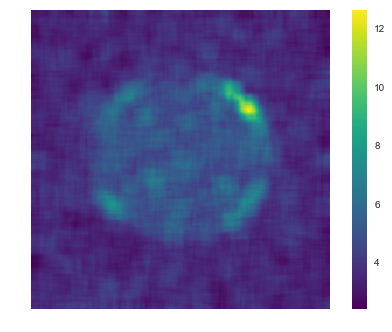

In [42]:
from medpy_noise import immerkaer, immerkaer_local

print(immerkaer(raw_diff))

iml = np.empty_like(raw_diff, dtype=float)
immerkaer_local(raw_diff, 16, output=iml)

plt.imshow(iml, cmap='viridis')
plt.grid(False)
plt.axis('off')
plt.colorbar();

This does show quite clearly that the variance inside the phantom is higher than outside. This doesn't seem to be large scale artefact either. Is there an issue with the statistics - difference of Ricians vs difference of Rayleighs? It does suggest that we are always going to get a higher noise value from a ROI inside the phantom than from the background ...

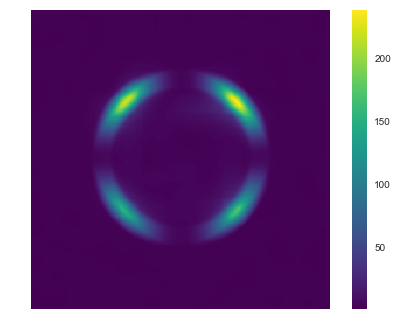

In [52]:
iml = np.empty_like(raw_a, dtype=float)
immerkaer_local(raw_a, 16, output=iml)

plt.imshow(iml, cmap='viridis')
plt.grid(False)
plt.axis('off')
plt.colorbar();

It doesn't look like Immerkaer's method helps that much in the orioginal images. The artefacts from the (fuzzy) edges are too severe.